In [1]:
from pathlib import Path
import os
cwd_path = Path.cwd(); set_path = str(cwd_path.parent.parent); os.chdir(set_path)

In [6]:
from TargetDistributions.DoubleWell import DoubleWellEnergy
import torch
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from FittedModels.utils import plot_distributions, plot_samples, plot_sampling_info, plot_divergences
torch.manual_seed(5)
from ImportanceSampling.VanillaImportanceSampler import VanillaImportanceSampling
from TargetDistributions.MoG import MoG
from TargetDistributions.Guassian_FullCov import Guassian_FullCov
from FittedModels.Models.DiagonalGaussian import DiagonalGaussian
from FittedModels.utils import plot_distributions
from FittedModels.train import LearntDistributionManager
from Utils.plotting_utils import plot_func2D, plot_distribution, plot_samples_single_dist
from Utils.numerical_utils import MC_estimate_true_expectation, expectation_function
from FittedModels.Models.FlowModel import FlowModel
from FittedModels.utils import plot_history
import matplotlib.pyplot as plt
from TargetDistributions.MoG import MoG
from TargetDistributions.MoG import custom_MoG

In [7]:
target = DoubleWellEnergy(2, a=-0.5, b=-6)

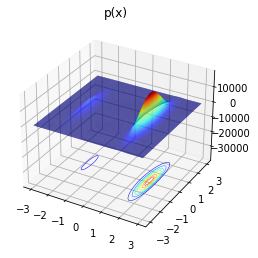

In [9]:
dist = plot_distribution(target, bounds=[[-3, 3], [-3, 3]], n_points=300)

# Let's fit with KL

In [13]:
dim=2
n_samples_estimation = int(1e5)
torch.manual_seed(0) # 0
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=3, scaling_factor=8) # , flow_type="RealNVP"
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="kl") 
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

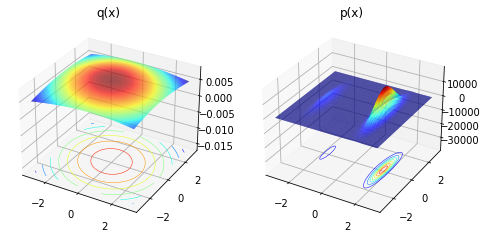

In [14]:
fig_before_train = plot_distributions(tester, bounds=[[-3, 3], [-3, 3]], n_points=100)

In [15]:
history = tester.train(5000, batch_size=int(1e4))

loss: -9.093287467956543, mean log p_x 7.461507797241211: 100%|████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [04:31<00:00, 18.41it/s]


In [16]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n"
      f"effective sample size before is {info_before['effective_sample_size'] / n_samples_estimation}\n"
      f"effective sample size after train is {info['effective_sample_size'] / n_samples_estimation}\n"
      f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 4.798250198364258 
estimate after training is 1.9912916421890259 
effective sample size before is 0.0274980291724205
effective sample size after train is 0.3255102336406708
variance in weights is 2.074174062727252e-06


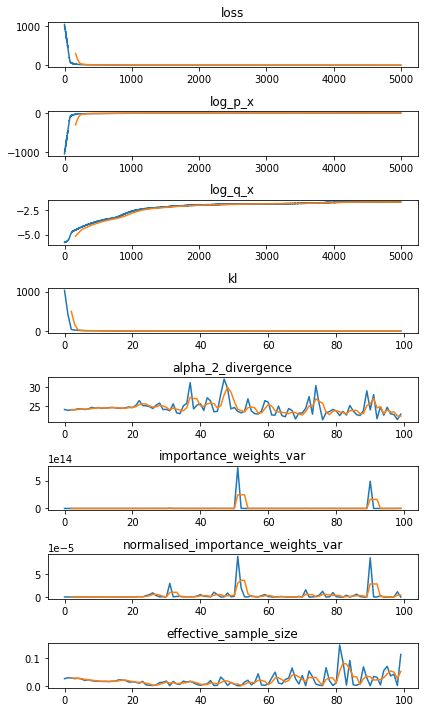

In [17]:
hist_fig = plot_history(history)

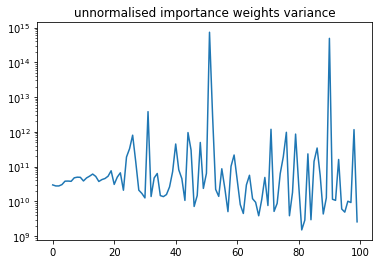

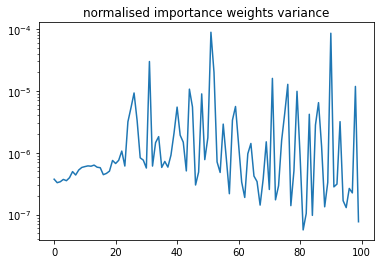

In [18]:
plot_sampling_info(history)

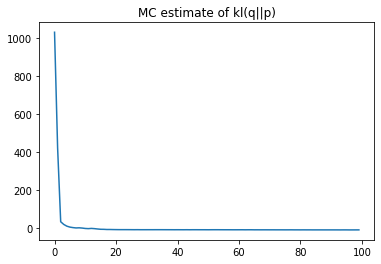

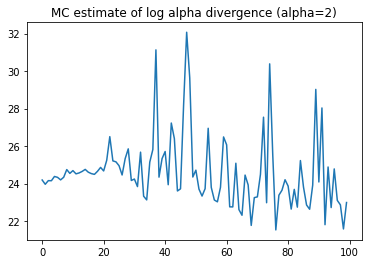

In [19]:
plot_divergences(history)

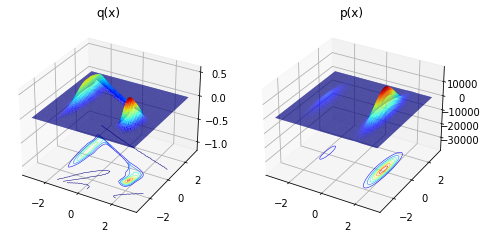

In [20]:
fig_after_train = plot_distributions(tester, bounds=[[-3, 3], [-3, 3]], n_points=100)

In [21]:
def plot_samples_single_dist(distribution, n_samples = 1000):
    samples_q = distribution.sample((n_samples,)).detach()
    fig, axs = plt.subplots(1)
    axs.scatter(samples_q[:, 0], samples_q[:, 1])
    axs.set_title("q(x) samples")

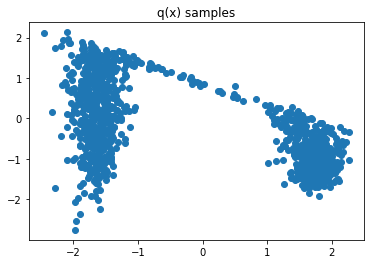

In [22]:
plot_samples_single_dist(tester.learnt_sampling_dist, n_samples=1000)

# Let's fit with alpha divergence

In [30]:
dim=2
n_samples_estimation = int(1e5)
batch_size = int(1e4) # needs big batch size for stability
epochs = 5000
torch.manual_seed(0) # 0
learnt_sampler = FlowModel(x_dim=dim , n_flow_steps=3, scaling_factor=8) # , flow_type="RealNVP"
tester = LearntDistributionManager(target, learnt_sampler, VanillaImportanceSampling, loss_type="DReG") 
expectation_before, info_before = tester.estimate_expectation(n_samples_estimation, expectation_function)

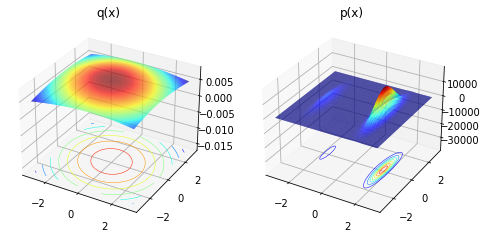

In [31]:
fig_before_train = plot_distributions(tester, bounds=[[-3, 3], [-3, 3]], n_points=100)

In [32]:
history = tester.train(epochs, batch_size=batch_size, clip_grad=True) #, break_on_inf=False) # epochs 1000

loss: -10.763686180114746, mean log p_x 2.4412424564361572: 100%|██████████████████████████████████████████████████████████████████████████████████| 5000/5000 [12:36<00:00,  6.61it/s]


In [33]:
expectation, info = tester.estimate_expectation(n_samples_estimation, expectation_function)

print(f"estimate before training is {expectation_before} \n"
      f"estimate after training is {expectation} \n"
      f"effective sample size before is {info_before['effective_sample_size'] / n_samples_estimation}\n"
      f"effective sample size after train is {info['effective_sample_size'] / n_samples_estimation}\n"
      f"variance in weights is {torch.var(info['normalised_sampling_weights'])}")

estimate before training is 3.9121663570404053 
estimate after training is 3.9744527339935303 
effective sample size before is 0.02672036923468113
effective sample size after train is 0.6717513203620911
variance in weights is 4.886463109143868e-11


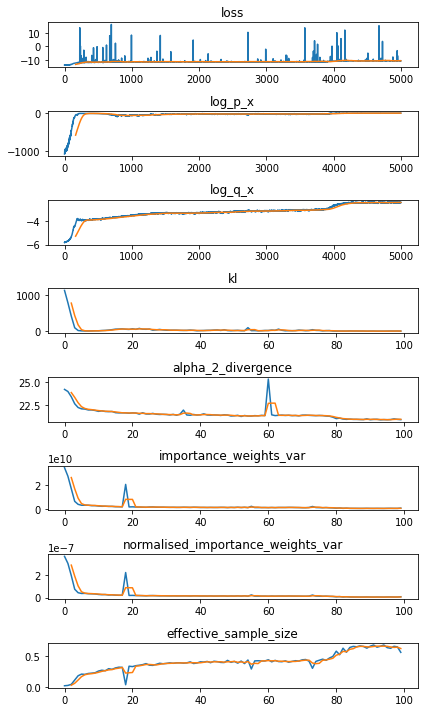

In [34]:
hist_fig = plot_history(history)

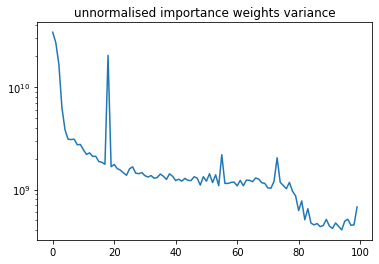

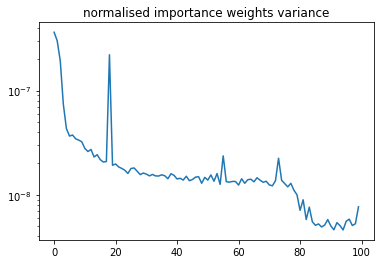

In [35]:
plot_sampling_info(history)

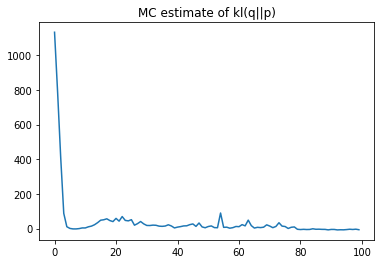

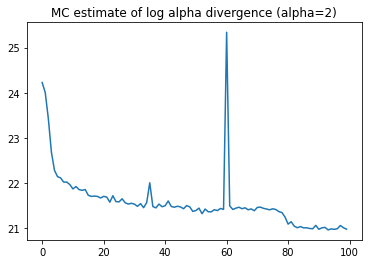

In [36]:
plot_divergences(history)

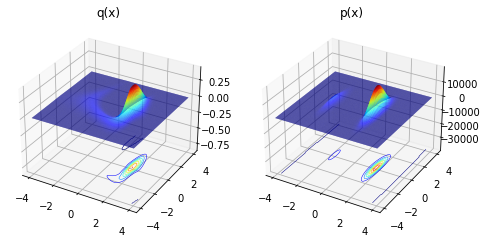

In [37]:
fig_after_train = plot_distributions(tester, bounds=[[-4, 4], [-4, 4]], n_points=150)

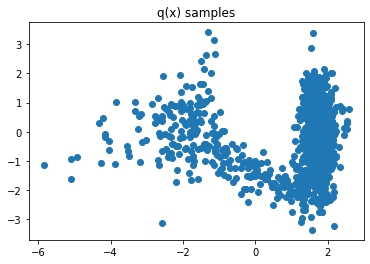

In [38]:
plot_samples_single_dist(tester.learnt_sampling_dist, n_samples=1000)